# Generate Mock Image and save it to a HDF5 file

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import urllib
import urllib2
import os
import slug
import h5py

from astropy.io import fits
from astropy import wcs
from astropy.table import Table, Column, vstack

import matplotlib.pyplot as plt

import galsim

from kungpao import imtools
from kungpao import io
from kungpao.display import display_single, IMG_CMAP, SEG_CMAP

from IPython.display import clear_output

plt.rc('text', usetex=True)
HSC_pixel_scale = 0.168

In [2]:
# Login NAOJ server
slug.login_naoj_server('/Users/jiaxuanli/Documents/HSC_config')

***
# Download background images according to the given catalog

## Import sky objects as the position of putting fake galaxies

In [12]:
pos_cat = Table.read('/Users/jiaxuanli/Research/HSC_Dragonfly_DECaLS/MockTest/fake_gal_pos.fits', format='fits')
pos_cat.add_column(Column(data=np.arange(0, len(pos_cat), 1)), name='index')
sersic_cat = Table.read('./GAMA_sersic_catalog_test.fits', format='fits')
sersic_cat = sersic_cat[np.logical_and.reduce([sersic_cat['Z']<0.4, sersic_cat['Z']>0.2])]
sersic_cat = Table(sersic_cat[[4, 25, 45]])
sersic_cat.add_column(Column(data=np.array([0, 1, 2])), name='index')
sersic_cat

CATAID,SPECID,SURVEY,RA,DEC,Z,NQ,PROB,R_PETRO,SURVEY_OLDCLASS,SURVEY_CLASS,CENFLUX_u,BACKFLUX_u,PSFNUM_u,PSFCHI2_u,PSFFWHM_u,NSEC_u,GALXCEN_u,GALYCEN_u,GALMAG_u,GALRE_u,GALINDEX_u,GALELLIP_u,GALPA_u,GALXCENERR_u,GALYCENERR_u,GALMAGERR_u,GALREERR_u,GALINDEXERR_u,GALELLIPERR_u,GALPAERR_u,GALRA_u,GALDEC_u,GALMAG10RE_u,GALMU0_u,GALMUE_u,GALMUEAVG_u,GALR90_u,GALCHI2FULL_u,GALNDOF_u,GALCHI2_u,GALPLAN_u,PRICHI2FULL_u,PRINFP_u,PRINDOF_u,PRICHI2_u,CENFLUX_g,BACKFLUX_g,PSFNUM_g,PSFCHI2_g,PSFFWHM_g,NSEC_g,GALXCEN_g,GALYCEN_g,GALMAG_g,GALRE_g,GALINDEX_g,GALELLIP_g,GALPA_g,GALXCENERR_g,GALYCENERR_g,GALMAGERR_g,GALREERR_g,GALINDEXERR_g,GALELLIPERR_g,GALPAERR_g,GALRA_g,GALDEC_g,GALMAG10RE_g,GALMU0_g,GALMUE_g,GALMUEAVG_g,GALR90_g,GALCHI2FULL_g,GALNDOF_g,GALCHI2_g,GALPLAN_g,PRICHI2FULL_g,PRINFP_g,PRINDOF_g,PRICHI2_g,CENFLUX_r,BACKFLUX_r,PSFNUM_r,PSFCHI2_r,PSFFWHM_r,NSEC_r,GALXCEN_r,GALYCEN_r,GALMAG_r,GALRE_r,GALINDEX_r,GALELLIP_r,GALPA_r,GALXCENERR_r,GALYCENERR_r,GALMAGERR_r,GALREERR_r,GALINDEXERR_r,GALELLIPERR_r,GALPAERR_r,GALRA_r,GALDEC_r,GALMAG10RE_r,GALMU0_r,GALMUE_r,GALMUEAVG_r,GALR90_r,GALCHI2FULL_r,GALNDOF_r,GALCHI2_r,GALPLAN_r,PRICHI2FULL_r,PRINFP_r,PRINDOF_r,PRICHI2_r,CENFLUX_i,BACKFLUX_i,PSFNUM_i,PSFCHI2_i,PSFFWHM_i,NSEC_i,GALXCEN_i,GALYCEN_i,GALMAG_i,GALRE_i,GALINDEX_i,GALELLIP_i,GALPA_i,GALXCENERR_i,GALYCENERR_i,GALMAGERR_i,GALREERR_i,GALINDEXERR_i,GALELLIPERR_i,GALPAERR_i,GALRA_i,GALDEC_i,GALMAG10RE_i,GALMU0_i,GALMUE_i,GALMUEAVG_i,GALR90_i,GALCHI2FULL_i,GALNDOF_i,GALCHI2_i,GALPLAN_i,PRICHI2FULL_i,PRINFP_i,PRINDOF_i,PRICHI2_i,CENFLUX_z,BACKFLUX_z,PSFNUM_z,PSFCHI2_z,PSFFWHM_z,NSEC_z,GALXCEN_z,GALYCEN_z,GALMAG_z,GALRE_z,GALINDEX_z,GALELLIP_z,GALPA_z,GALXCENERR_z,GALYCENERR_z,GALMAGERR_z,GALREERR_z,GALINDEXERR_z,GALELLIPERR_z,GALPAERR_z,GALRA_z,GALDEC_z,GALMAG10RE_z,GALMU0_z,GALMUE_z,GALMUEAVG_z,GALR90_z,GALCHI2FULL_z,GALNDOF_z,GALCHI2_z,GALPLAN_z,PRICHI2FULL_z,PRINFP_z,PRINDOF_z,PRICHI2_z,fluxscale,nbands,logmstar,dellogmstar,logmoverl_i,dellogmoverl_i,logage,dellogage,logtau,dellogtau,index
,,,deg,deg,,,,mag,,,counts,counts,,,arcsec,,pix,pix,mag,arcsec,,,deg,pix,pix,mag,arcsec,,,deg,deg,deg,mag,mag / arcsec2,mag / arcsec2,mag / arcsec2,arcsec,,,,,,,,,counts,counts,,,arcsec,,pix,pix,mag,arcsec,,,deg,pix,pix,mag,arcsec,,,deg,deg,deg,mag,mag / arcsec2,mag / arcsec2,mag / arcsec2,arcsec,,,,,,,,,counts,counts,,,arcsec,,pix,pix,mag,arcsec,,,deg,pix,pix,mag,arcsec,,,deg,deg,deg,mag,mag / arcsec2,mag / arcsec2,mag / arcsec2,arcsec,,,,,,,,,counts,counts,,,arcsec,,pix,pix,mag,arcsec,,,deg,pix,pix,mag,arcsec,,,deg,deg,deg,mag,mag / arcsec2,mag / arcsec2,mag / arcsec2,arcsec,,,,,,,,,counts,counts,,,arcsec,,pix,pix,mag,arcsec,,,deg,pix,pix,mag,arcsec,,,deg,deg,deg,mag,mag / arcsec2,mag / arcsec2,mag / arcsec2,arcsec,,,,,,,,,,,dex(Msun),dex(Msun),"dex(Msun/Lsun,i)","dex(Msun/Lsun,i)",dex(yr),dex(yr),dex(yr),dex(yr),
int32,str33,str9,float64,float64,float32,int16,float32,float32,int16,int16,float32,float32,int16,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,int32,float32,int16,float32,int16,int32,float32,float32,float32,int16,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,int32,float32,int16,float32,int16,int32,float32,float32,float32,int16,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,int32,float32,int16,float32,int16,int32,float32,float32,float32,int16,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,int32,float32,int16,float32,int16,int32,float32,float

Size (in pixel): [999, 1003]
Angular size (in arcsec): [167.83200000000002, 168.50400000000002]
The center of this image: [499.5, 501.5]


<Figure size 432x288 with 0 Axes>

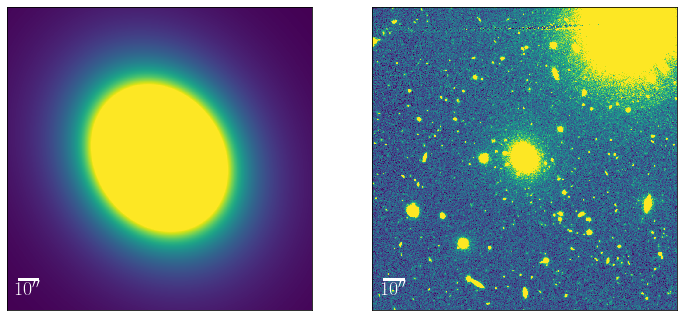

Size (in pixel): [999, 1003]
Angular size (in arcsec): [167.83200000000002, 168.50400000000002]
The center of this image: [499.5, 501.5]


<Figure size 432x288 with 0 Axes>

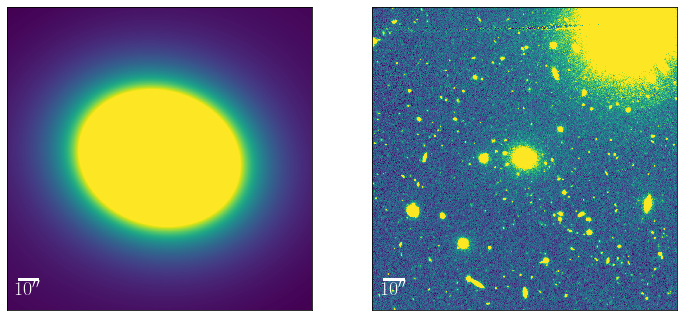

Size (in pixel): [999, 1003]
Angular size (in arcsec): [167.83200000000002, 168.50400000000002]
The center of this image: [499.5, 501.5]


<Figure size 432x288 with 0 Axes>

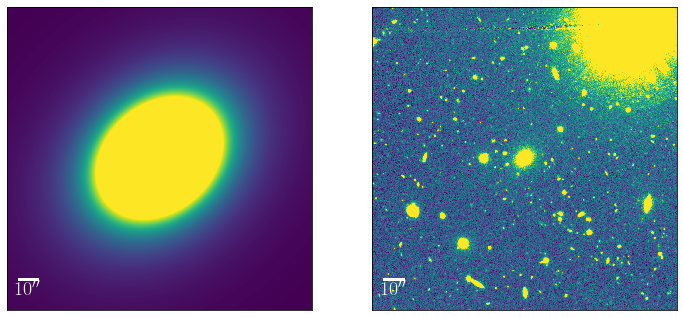

<Figure size 432x288 with 0 Axes>

In [13]:
if not os.path.isdir('HDF5'):
    os.mkdir('HDF5')
path = './HDF5/'

for obj in pos_cat[:50]:
    clear_output()
    i = obj['index']
    filename = path + 'RealMockGalaxy-'+ ("%03d" % i) + '.h5'
    if os.path.isfile(filename):
        os.remove(filename)
    
    # Download background image
    size = 500 # pixel, half_size. The actual size will be 1000*1000.
    url = slug.gen_url_hsc_s18a(obj['i_ra'], obj['i_dec'], 
                       size * HSC_pixel_scale, 
                       size * HSC_pixel_scale, 'r')[0]
    fits_data = fits.open(url, cache=False)
    
    # Construct HDF5 file
    f = h5py.File(filename,'w')
    dt = h5py.special_dtype(vlen=str)
    
    info = {}
    info['edition'] = 's18a'
    info['ra'] = obj['i_ra']
    info['dec'] = obj['i_dec']
    info['size(pix)'] = [fits_data[1].shape[0], fits_data[1].shape[1]]
    f.create_dataset('info', data=str(info))
    
    g1 = f.create_group('Background')
    r = g1.create_group('r-band')
    r.create_dataset('primary_header', data=fits_data[0].header.tostring(), dtype=dt)
    r.create_dataset('image', data=fits_data[1].data)
    r.create_dataset('image_header', data=fits_data[1].header.tostring(), dtype=dt)
    r.create_dataset('mask', data=fits_data[2].data)
    r.create_dataset('mask_header', data=fits_data[2].header.tostring(), dtype=dt)
    r.create_dataset('variance', data=fits_data[3].data)
    r.create_dataset('variance_header', data=fits_data[3].header.tostring(), dtype=dt)
    
    g2 = f.create_group('ModelImage')
    r = g2.create_group('r-band')
    g3 = f.create_group('MockImage')
    r = g3.create_group('r-band')
    
    # Parameters of fake galaxy
    for galaxy in sersic_cat:
        flux = 10**((27.0 - galaxy['GALMAG_r']) / 2.5)
        gal_flux = flux  # total counts on the image
        gal_rh = galaxy['GALRE_r'] # arcsec
        gal_q = 1 - galaxy['GALELLIP_r']  # b/a
        gal_beta = galaxy['GALPA_r']  # degrees
        psf_rh = 0.7  # arcsec
        # Sersic index
        sersic_index = galaxy['GALINDEX_r']
        slug.h5_gen_mock_image(filename, slug.HSC_pixel_scale, 'r-band', 
                       gal_flux, gal_rh, gal_q, sersic_index, gal_beta, psf_rh, 
                               groupname='model-' + str(galaxy['index']))
        
        info = {}
        info['redshift'] = galaxy['Z']
        info['r_mag'] = galaxy['GALMAG_r']
        info['r_e'] = galaxy['GALRE_r']
        info['pa'] = galaxy['GALPA_r']
        info['n'] = galaxy['GALINDEX_r']
        f['ModelImage']['r-band']['model-' + str(galaxy['index'])].create_dataset('info', data=str(info))
        f['MockImage']['r-band']['model-' + str(galaxy['index'])].create_dataset('info', data=str(info))
    f.close()
    fits_data.close()

In [14]:
f = h5py.File('./HDF5/RealMockGalaxy-000.h5')
slug.h5_print_attrs(f)
f.close()

Background
Background/r-band
Background/r-band/image
Background/r-band/image_header
Background/r-band/mask
Background/r-band/mask_header
Background/r-band/primary_header
Background/r-band/variance
Background/r-band/variance_header
MockImage
MockImage/r-band
MockImage/r-band/model-0
MockImage/r-band/model-0/info
MockImage/r-band/model-0/mockimage
MockImage/r-band/model-1
MockImage/r-band/model-1/info
MockImage/r-band/model-1/mockimage
MockImage/r-band/model-2
MockImage/r-band/model-2/info
MockImage/r-band/model-2/mockimage
ModelImage
ModelImage/r-band
ModelImage/r-band/model-0
ModelImage/r-band/model-0/info
ModelImage/r-band/model-0/modelimage
ModelImage/r-band/model-1
ModelImage/r-band/model-1/info
ModelImage/r-band/model-1/modelimage
ModelImage/r-band/model-2
ModelImage/r-band/model-2/info
ModelImage/r-band/model-2/modelimage
info
